In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn import preprocessing 
import numpy as np
import os

In [2]:
cwd = os.getcwd()
test_set = pd.DataFrame(pd.read_csv(os.path.join(cwd, 'datasets/test_data.csv')))
dataset = pd.DataFrame(pd.read_csv(os.path.join(cwd, 'datasets/train_data.csv')))

In [3]:
dataset.head()

,ID,parents,has_nurs,form,children,housing,finance,social,health,app_status
0,1,usual,less_proper,complete,3,critical,convenient,problematic,not_recom,0
1,2,pretentious,very_crit,completed,1,convenient,inconv,nonprob,not_recom,0
2,3,pretentious,proper,incomplete,1,less_conv,convenient,slightly_prob,priority,1
3,4,great_pret,improper,complete,1,convenient,convenient,nonprob,recommended,1
4,5,great_pret,less_proper,completed,1,convenient,convenient,slightly_prob,priority,1


In [4]:
dataset.shape

(10368, 10)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10368 entries, 0 to 10367
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          10368 non-null  int64 
 1   parents     10368 non-null  object
 2   has_nurs    10368 non-null  object
 3   form        10368 non-null  object
 4   children    10368 non-null  object
 5   housing     10368 non-null  object
 6   finance     10368 non-null  object
 7   social      10368 non-null  object
 8   health      10368 non-null  object
 9   app_status  10368 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 810.1+ KB


In [6]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        2592 non-null   int64 
 1   parents   2592 non-null   object
 2   has_nurs  2592 non-null   object
 3   form      2592 non-null   object
 4   children  2592 non-null   object
 5   housing   2592 non-null   object
 6   finance   2592 non-null   object
 7   social    2592 non-null   object
 8   health    2592 non-null   object
dtypes: int64(1), object(8)
memory usage: 182.4+ KB


In [7]:
dataset[dataset.isnull().any(axis=1)]    # any null records available?
del dataset['ID']
del test_set['ID']

### Label Encoding

In [8]:
label_encoder = preprocessing.LabelEncoder()

In [9]:
# Label Encoding for ordinal columns
def clean_ordinal(dataset):
    columns_ordinal = ['parents', 'children', 'has_nurs', 'housing']

    for column in columns_ordinal:
        dataset[column] = label_encoder.fit_transform(dataset[column])
    return dataset

### One Hot Encoding

In [10]:
onehot_encoder = preprocessing.OneHotEncoder(drop='first')

In [11]:
# OneHotEncoding for nominal columns
def clean_nominal(dataset):
    columns_nominal = ['form', 'finance', 'social', 'health']

    cleaned_dataset = dataset

    for column in columns_nominal:
        X = onehot_encoder.fit_transform(dataset[column].values.reshape(-1, 1)).toarray()
        # create dataframe from encoded data
        dataset_onehot = pd.DataFrame(X, columns = [column + '_' + str(i) for i in range(X.shape[1])]) 
        # update dataset -> cleaned_dataset
        cleaned_dataset = pd.concat([dataset_onehot, cleaned_dataset], axis=1)
        # remove encoded column from dataset
        del cleaned_dataset[column]
    return cleaned_dataset

In [12]:
# Test set cleaning
test_set = clean_ordinal(test_set)
cleaned_test_set = clean_nominal(test_set)
cleaned_test_set.head()

,health_0,health_1,social_0,social_1,finance_0,form_0,form_1,form_2,parents,has_nurs,children,housing
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,3,0,0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,3,0,0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2,3,0,0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2,3,0,2
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,3,0,2


In [13]:
# splitting complete ds to independant and dependata vars
cleaned_dataset = clean_nominal(clean_ordinal(dataset))
cleaned_dataset.head()

,health_0,health_1,social_0,social_1,finance_0,form_0,form_1,form_2,parents,has_nurs,children,housing,app_status
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,2,2,1,0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,4,0,0,0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,3,0,2,1
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,1
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,2,0,0,1


### Independant dependant var splitting

In [14]:
x = cleaned_dataset.iloc[:, 1:-1]
y = cleaned_dataset.iloc[:, -1]

### Normalizing

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 

x = scaler.fit_transform(x)


### Test train split

In [16]:
# splitting dataset to training and testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [17]:
from sklearn.neighbors import KNeighborsClassifier

### Cross Validation

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors':np.arange(1,50)}

In [19]:
knn = KNeighborsClassifier()

knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(x, y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [20]:
knn_cv.best_score_

0.7873281912228725

In [21]:
knn_cv.best_params_

{'n_neighbors': 12}

## Classifier

In [22]:
# max accuracy by 10-cv K=47, 5-cv K=43

knn = KNeighborsClassifier(n_neighbors=12)

In [23]:
# model fitting
knn.fit(x, y)

KNeighborsClassifier(n_neighbors=12)

In [24]:
# Accuracy
knn.score(x_test, y_test)

0.8106718097074895

### Confusion Matrix

In [25]:
from sklearn.metrics import confusion_matrix


y_pred = knn.predict(x_test)

In [26]:
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1876,133,2009
1,456,646,1102
All,2332,779,3111


### Classification report

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      2009
           1       0.83      0.59      0.69      1102

    accuracy                           0.81      3111
   macro avg       0.82      0.76      0.78      3111
weighted avg       0.81      0.81      0.80      3111



### ROC-AUC

In [28]:
y_pred_proba = knn.predict_proba(x_test)[:,1]
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

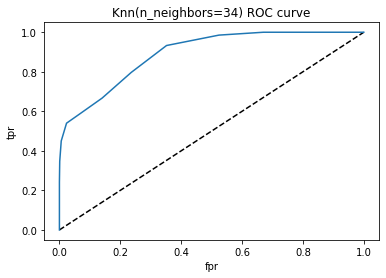

In [29]:
import matplotlib.pyplot as plt

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=34) ROC curve')
plt.show()

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.8917064678998952

### New prediction

In [31]:
del cleaned_test_set['health_0']

In [33]:
cleaned_test_set = scaler.fit_transform(cleaned_test_set)

In [34]:
arr = knn.predict(cleaned_test_set)
np.savetxt("predicted/pred_knn.csv", np.dstack((np.arange(1, arr.size+1),arr))[0],"%d,%d",header="ID,app_status")


In [ ]:
0.8606740654763435 | 